<a href="https://colab.research.google.com/github/tiboas/End-to-end-Learning/blob/main/End_to_end_Learning_AWGN_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda
import keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
 
from keras.models import Model
import matplotlib.pyplot as plt
from scipy import optimize
 
from IPython.core.display import HTML
from IPython.core.display import Video
#from IPython.display import HTML # to show the animation in Jupyter

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
pip install celluloid

In [3]:
import celluloid
from celluloid import Camera # getting the camera

In [4]:
Nsamples = 100000
M = 64
N = np.random.randint(0,M,Nsamples) # *4 since 4 16QAM has 4 bits/symbol
N_ohe = to_categorical(N)

# SNR for training
SNR_train = 16

# STDV of the noise:
AWGN_sigma = np.sqrt(1 / (2 * 10 ** (SNR_train / 10)))


In [5]:
# Power normalization for training:
def normalization(x):
    return x / K.sqrt(2 * (K.mean(x ** 2)))

def AWGN(x, sigma):
    noise = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)
    y = x + noise
    return y

In [6]:
N_units = 128;
inputs = keras.Input(shape=(M,))

#Encoder
x = Dense(4*N_units, activation="relu",kernel_initializer='he_normal')(inputs)
x = Dense(N_units, activation="relu",  kernel_initializer='he_normal')(x)
x = Dense(N_units, activation="relu",   kernel_initializer='he_normal')(x)
x = Dense(2, activation="linear",   kernel_initializer='random_normal', bias_initializer='zeros')(x)

# AWGN channel
x_normalized = Lambda(normalization)(x)
y = Lambda(AWGN, arguments={'sigma': AWGN_sigma})(x_normalized)

# Decoder
yhat = Dense(N_units, activation="relu",kernel_initializer='he_normal')(y)
yhat = Dense(N_units, activation="relu",kernel_initializer='he_normal')(yhat)
yhat = Dense(4*N_units, activation="relu",kernel_initializer='he_normal')(yhat)
outputs = Dense(M, activation="softmax")(yhat)

model = keras.Model(inputs=inputs, outputs=outputs, name="AWGNchannelEncoder")

In [7]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1= 0.95,beta_2=0.99),
    metrics=["accuracy"],
)

40/40 [==============================] - 1s 15ms/step - loss: 3.4200 - accuracy: 0.1162 - val_loss: 2.0035 - val_accuracy: 0.2851
Setting LR to: 0.000985
40/40 [==============================] - 0s 6ms/step - loss: 1.8036 - accuracy: 0.3055 - val_loss: 1.6628 - val_accuracy: 0.3296
Setting LR to: 0.000970225
40/40 [==============================] - 0s 6ms/step - loss: 1.6297 - accuracy: 0.3380 - val_loss: 1.5668 - val_accuracy: 0.3581
Setting LR to: 0.00095567165
40/40 [==============================] - 0s 6ms/step - loss: 1.5328 - accuracy: 0.3970 - val_loss: 1.4440 - val_accuracy: 0.4652
Setting LR to: 0.00094133656
40/40 [==============================] - 0s 6ms/step - loss: 1.3632 - accuracy: 0.4891 - val_loss: 1.2301 - val_accuracy: 0.5509
Setting LR to: 0.0009272165
40/40 [==============================] - 0s 6ms/step - loss: 1.1445 - accuracy: 0.5813 - val_loss: 1.0604 - val_accuracy: 0.6080
Setting LR to: 0.00091330823
40/40 [==============================] - 0s 6ms/step - loss

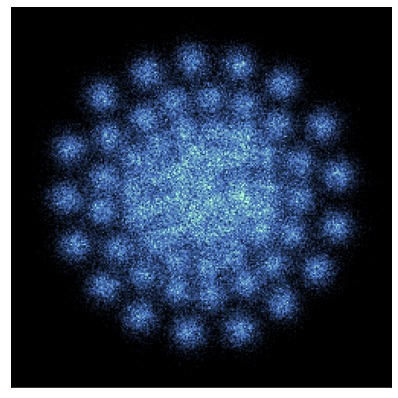

In [8]:
Nepochs = 60
Nsamples = 50000
Nsamples_validate = 200000

#Figure and camera to create animation that shows the constellation updating:
fig = plt.figure(figsize=(7,7))
camera = Camera(fig) # To capture evaluation of constellation

acc = np.zeros((Nepochs))
acc_val = np.zeros((Nepochs))
for k in range(Nepochs):
  XX = model.input 
  YY = model.layers[6].output
  new_model = Model(XX, YY)
  N = np.random.randint(0,M,Nsamples_validate) # *4 since 4 16QAM has 4 bits/symbol
  N_ohe = to_categorical(N)
  foo = new_model.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
  
  heatmap, xedges, yedges = np.histogram2d(foo[:,0], foo[:,1], bins=250, range=[[-2,2],[-2,2]])
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.imshow(heatmap.T, extent=extent, origin='lower',cmap=LinearSegmentedColormap.from_list('my_cmap', ['#000000','#4770BD','#A4F7C9','#E4FFD0'], N=250))
  plt.xticks([])
  plt.yticks([])
  camera.snap()

  N = np.random.randint(0,M,Nsamples) # *4 since 4 16QAM has 4 bits/symbol
  N_ohe = to_categorical(N)
  history = model.fit(N_ohe, N_ohe, batch_size=np.int32(Nsamples/50), epochs=1, validation_split=0.2)
  acc[k] = np.array(history.history['accuracy'])
  acc_val[k] = np.array(history.history['val_accuracy'])

  #Decrease LR:
  K.set_value(model.optimizer.learning_rate, K.get_value(model.optimizer.learning_rate) * 0.985)
  print('Setting LR to: ' + str(K.get_value(model.optimizer.learning_rate)))

Text(0.5, 0, 'Epoch #')

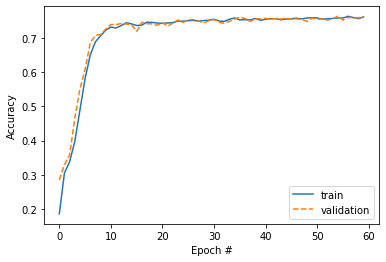

In [9]:
plt.figure()
plt.plot( acc)
plt.plot( acc_val,'--')
plt.legend(['train','validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')

In [10]:
animation = camera.animate(repeat=True) # animation ready
animation.save('training.mp4')
#This works in notebook
#video = HTML(animation.to_html5_video()) # displaying the animation
#video

#To view video on github:
vid = Video("training.mp4", embed=True)
vid

In [11]:
def noiseScaling(X,Y,h):
  return np.matmul((h*X-Y), (h*X-Y).conj().transpose())

def calcMI(X,Y, const, P):
  realmin = np.finfo(float).tiny #define a min value to avoid dividing by 0
  n = len(X)
  M = len(const)

  #Normalize X, Y, and the constellation:
  X = X/np.sqrt(np.mean(np.abs(X)**2))
  Y = Y/np.sqrt(np.mean(np.abs(Y)**2))
  const = const/np.sqrt(np.mean(np.abs(const)**2))

  #Scale the signal with respect to signal+noise:
  h_min = optimize.fminbound(noiseScaling, 0, 2.5, xtol=1e-6, maxfun=500,args=(X,Y,))
  N0 = np.real((1-h_min**2)/(h_min**2))
  Y = Y/h_min

  #Calculate the mutual information:
  qYonX = (1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(X))**2-(np.imag(Y)-np.imag(X))**2)/N0))
  qY = 0
  for i in range(M):
    qY = qY + P[i]*(1/(np.pi*N0)*np.exp((-(np.real(Y)-np.real(const[i]))**2-(np.imag(Y)-np.imag(const[i]))**2)/N0))
  qY = np.real(qY)
  qYonX = np.real(qYonX)
  MI=1/n*np.sum(np.log2(np.maximum(qYonX,realmin)/np.maximum(qY,realmin)))
  return MI

In [12]:
  XX = model.input 
  YY = model.layers[4].output
  YY_ch = model.layers[6].output
  encoderOutput = Model(XX, YY)
  chOutput = Model(XX, YY_ch)
  N = np.random.randint(0,M,Nsamples_validate) # *4 since 4 16QAM has 4 bits/symbol
  N_ohe = to_categorical(N)
  X = encoderOutput.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
  Y = chOutput.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
  const = np.unique(X,0)

(64,)


(-1.9326281029560632,
 1.8315550062583081,
 -1.79162608815587,
 1.7738313201306113)

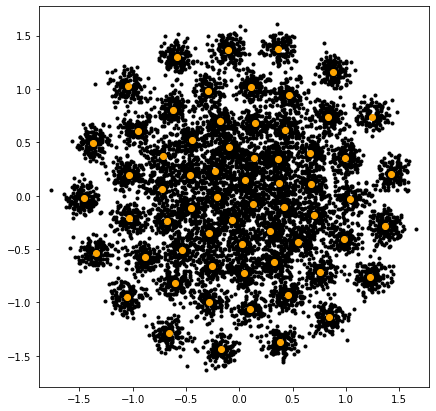

In [13]:
#const = np.unique(np.round(10*X)/10,axis=0)
N = np.array(range(M)) # *4 since 4 16QAM has 4 bits/symbol
N_ohe = to_categorical(N)
const = encoderOutput.predict(N_ohe, batch_size=np.int32(len(N_ohe)/4))
const = const[:,0] + 1j*const[:,1]
const= const-np.mean(const) 
const = const/np.sqrt(np.sum(np.abs(const)**2)/len(const))
print(np.shape(const))
Nsamples_MI = 10000
S = np.random.randint(0,len(const),Nsamples_MI)

SNRdB= 25;
SNR = 10**(SNRdB/10)
x = const[S]
Esig=np.sum(np.abs(x)**2)/len(x);

y = x + np.sqrt(Esig/(SNR/2))*(np.random.randn(len(x))+1j*np.random.randn(len(x))); 
plt.figure(figsize=(7,7))
plt.plot(y.real,y.imag,'k.')
plt.plot(const.real, const.imag,'o',color='orange')
plt.axis('equal')


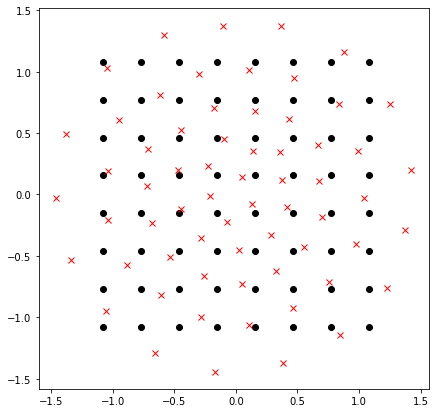

In [14]:
ctr = 0
constQAM = []
for ii in range(-7,7+1,2):
  for jj in range(-7,7+1,2):
    constQAM = np.append(constQAM, ii+1j*jj)

constQAM = constQAM/np.sqrt(np.sum(np.abs(constQAM)**2)/len(constQAM))

plt.figure(figsize=(7,7))
plt.plot(constQAM.real,constQAM.imag,'ko',markeredgecolor='k')
plt.plot(const.real,const.imag,'x',color='red', markeredgecolor='red')

NsymbolsSNRsweep= 50000
PQAM =  np.ones((len(constQAM)))/len(constQAM) 

SNRdB_vector = range(0,35,1)
MI = []
MI_AOC = []
for SNRdB in SNRdB_vector:
    SNR = 10**(SNRdB/10)

    #64QAM
    s = np.random.randint(0,len(constQAM),NsymbolsSNRsweep)
    x = constQAM[s]
    _,P = np.unique(x,return_counts=True)
    P = P / np.sum(P)
    y = x + np.sqrt(1/(2*SNR))*(np.random.randn(len(x))+1j*np.random.randn(len(x))); 
    MIthis = calcMI(x,y,constQAM,P)
    MI = np.append(MI,MIthis)

    #NN Constellation
    sAOC = np.random.randint(0,len(const),NsymbolsSNRsweep)
    xAOC= const[S]
    _,PAOC = np.unique(xAOC,return_counts=True)
    PAOC= PAOC / np.sum(PAOC)
    yAOX = xAOC +np.sqrt(1/(2*SNR))*(np.random.randn(len(xAOC))+1j*np.random.randn(len(xAOC))); 
    MIthis_AOC = calcMI(xAOC,yAOX,const,PAOC)
    MI_AOC = np.append(MI_AOC,MIthis_AOC)

Text(0, 0.5, 'Achievable Information Rate Gain [bit/symbol]')

<Figure size 432x288 with 0 Axes>

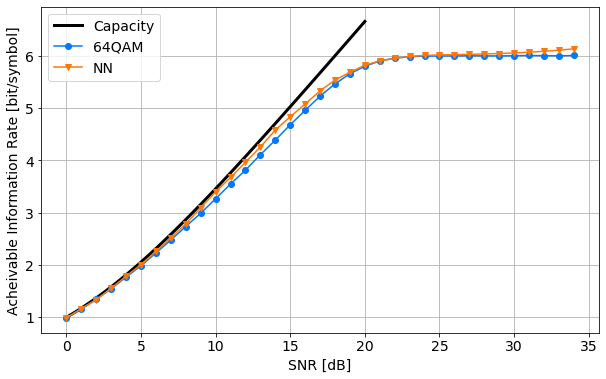

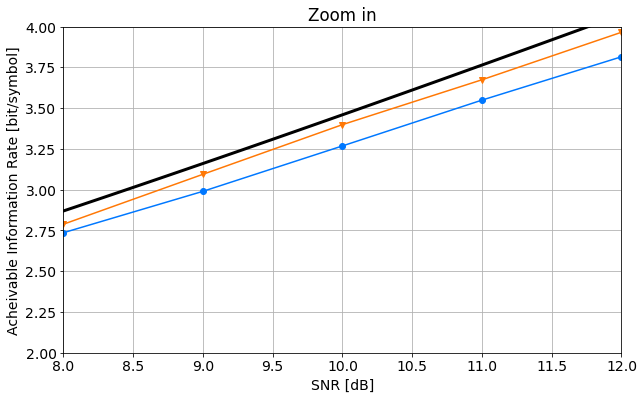

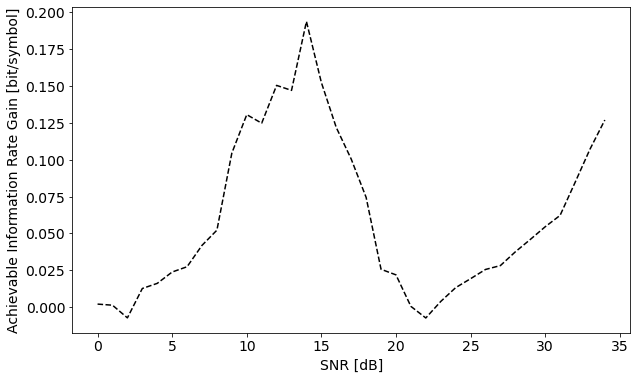

In [15]:
plt.figure()
SNRdBsh = np.linspace(0,20,100)
SNR_sh = 10**(SNRdBsh/10)
C = np.log2(1 + SNR_sh)
pColor  = np.array([255,120,5])/255
pColor2 = np.array([0,120,255])/255
plt.rcParams.update({'font.size': 14}) #set fontsize
plt.figure(figsize=(10,6))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(np.array(SNRdB_vector),MI,'o-', color=pColor2)
plt.plot(np.array(SNRdB_vector),MI_AOC,'v-',color=pColor)
plt.grid('minor')
plt.legend(['Capacity','64QAM','NN'])
plt.ylabel('Acheivable Information Rate [bit/symbol]')
plt.xlabel('SNR [dB]')

plt.figure(figsize=(10,6))
plt.plot(SNRdBsh,C,'k', linewidth=3)
plt.plot(np.array(SNRdB_vector),MI,'o-', color=pColor2)
plt.plot(np.array(SNRdB_vector),MI_AOC,'v-',color=pColor)
plt.grid('minor')
plt.xlim([8, 12])
plt.ylim([2,4])
plt.ylabel('Acheivable Information Rate [bit/symbol]')
plt.title('Zoom in')
plt.xlabel('SNR [dB]')

plt.figure(figsize=(10,6))
plt.plot(np.array(SNRdB_vector),MI_AOC-MI,'k--')
plt.xlabel('SNR [dB]')
plt.ylabel('Achievable Information Rate Gain [bit/symbol]')
